In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from scipy.optimize import curve_fit


## Creating Bak-Sneppen model

Steps:
Inititalize percolation grid
Start time loop
For every time iteration:
    Calculate probabilities that neighbours change

In [2]:
class SimulationGrid:
    '''Class for running Bak Sneppen model on a 2D grid'''
    def __init__(self, size, lambda_rate = 0.5, low=0.0, high=1.0):
        
        self.size = size
        self.threshold = []
        self.low = low
        self.high = high
        self.fitness_max = -1
        self.minima = []
        self.history = []
        self.num_iterations = 0
        self.avalanche_length = []
        self.current = self.initialize_grid()
        self.lambda_rate = lambda_rate  # Adjust as needed
        # Schedule the first information event
        self.time_for_next_info = np.random.exponential(scale=1/self.lambda_rate)
        
    def restart(self):
        '''Restores simulation to initial state and resets attributes'''
        self.current = self.history[0]
        self.history = []
        self.minima = []
        self.threshold_fitness = []
        self.fitness_max = -1

    def initialize_grid(self):
        '''Initalizes 2D grid with fitness values sampled from uniform distribution'''
        np.random.seed(123)
        return np.array([[np.random.uniform(self.low, self.high) for _ in range(self.size)] for _ in range(self.size)])

    def visualize(self):
        '''Visualizes latest iteration of the model'''
        cmap = 'viridis'
        plt.imshow(self.current, cmap=cmap, interpolation='nearest')
        plt.title('2D Grid Initialized with Uniform Distribution')
        plt.colorbar()
        plt.show()

    def draw_value(self):
        '''Draws fitness value from a uniform distribution'''
#         return np.random.normal(loc=self.mean, scale=self.std, size=(self.size, self.size))
        return np.random.uniform(self.low, self.high)

    def avalanche_frequencies(self):
        '''Calculates avalanche size frequency distribution for current'''
        freq = {}
        for value in self.avalanche_length:
            if value in freq:
                freq[value] += 1
            else:
                freq[value] = 1
                
        lst = np.array([[key,freq[key]] for key in freq])
        sorted_indices = np.argsort(lst[:, 0])
        
        # Use the sorted indices to sort the array
        sorted_frequencies = lst[sorted_indices]
        
        return sorted_frequencies
    
    def introduce_new_information(self, current_time):
        """
        Introduces new fitness values to random sites within the grid, simulating the impact of new information on the system.
        
        This method updates the fitness values based on a perturbation, which represents the random influence of external information. 
        The updates occur only if the current simulation time has reached or surpassed the scheduled time for new information.
        
        Parameters:
        current_time (int): The current timestep in the simulation.
        """
        if current_time >= self.time_for_next_info:
            num_sites = np.random.randint(10, 20)  # Number of sites to update
            noise_strength = 0.2  # Control the strength of the noise

            for _ in range(num_sites):
                i, j = np.random.randint(0, self.size, 2)
                perturbation = np.random.uniform(-noise_strength, noise_strength)
                new_fitness = self.current[i, j] + perturbation
                self.current[i, j] = np.clip(new_fitness, self.low, self.high)


            # Schedule the next information event
            self.time_for_next_info += np.random.exponential(scale=1/self.lambda_rate)
            
    def adjust_neighbor_fitness(self, i, j, bias=None):
        """
        Adjusts the fitness of a neighbor based on its original value.
        The adjustment weight is randomly chosen from U(0,1) and the direction (+ or -)
        is determined by a Bernoulli trial.
        """
        original_value = self.current[i, j]
        weight = np.random.uniform(0, 1)  # Weight is randomly chosen from U(0,1)
        k = bias
        change_direction = 1 if np.random.rand() < (0.5-k) else -1 # Direction is determined by a Bernoulli trial
#         change_direction = -1
        adjustment = original_value * weight * change_direction
        new_value = original_value + adjustment

        # Ensure the new value is within the bounds -> [0,1]
        return max(min(new_value, self.high), self.low)

    def run_iterations(self, iterations, bias =0 ,random_events = False, lambda_rate = 0.9,event_fitness=0.1, save=False):
        self.num_iterations= iterations
        avalanche_size = 0
        fitness_max = 0
        for t in range(iterations):
            
            # Introduce new information if the time has come
            if random_events:
                self.introduce_new_information(t)
    
            
            #Choosing to save values 
            if save:
                self.history.append(self.current.copy())  # Use copy to save the state, not a reference

            # Getting min index and saving minimum value
            min_index = np.unravel_index(self.current.argmin(), self.current.shape)
            minimum = self.current[min_index[0], min_index[1]]
            self.minima.append(minimum)
            
            
            #Updating fitness threshold and saving
            avalanche_size += 1
            if fitness_max < minimum:
                    self.avalanche_length.append(avalanche_size)
                    self.threshold.append((t,minimum))
                    fitness_max = minimum
                    avalanche_size = 0 
    

            # I could make this part more efficient but too lazy for now
            neighbors = [
                (min_index[0] - 1, min_index[1]),  # Above
                (min_index[0] + 1, min_index[1]),  # Below
                (min_index[0], min_index[1] - 1),  # Left
                (min_index[0], min_index[1] + 1)   # Right
            ]

            # Keeping only 'useful' indexes
            indices = [(i, j) for i, j in neighbors if 0 <= i < self.current.shape[0] and 0 <= j < self.current.shape[1]]

#             Updating neighbors and worst value
#             for index in indices:
#                 i, j = index
#                 self.current[i, j] = self.draw_value()

#             self.current[min_index[0], min_index[1]] = self.draw_value()
            
            for i, j in indices:
                if bias: 
                    self.current[i, j] = self.adjust_neighbor_fitness(i, j, bias)
                else:
                    self.current[i, j] = self.draw_value()
                
            self.current[min_index[0], min_index[1]] = self.draw_value()
        
        self.threshold.append((t, fitness_max))
        self.threshold = np.array(self.threshold)


# An avalanche is a cascade of fitness changes below the threshold (i.e. all the blinking dots below the
# line), although this behavior also results in random fitness changes above the line. An avalanche lasts
# as long as any activity remains below the threshold, and the length of the avalanche is the number of
# mutations below the threshold.

## Running and visualizing grid

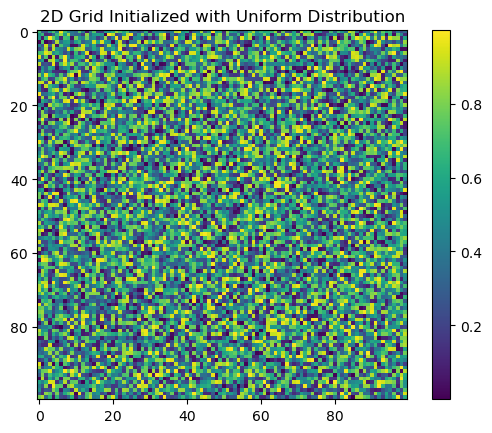

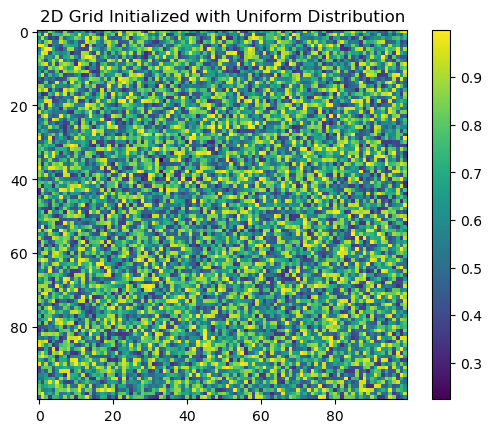

In [3]:
grid = SimulationGrid(100)
grid.visualize()
plt.show()
#  run_iterations(self, iterations, num_clusters = 0, lambda_rate = 0.9,event_fitness=0.1, save=False)

grid.run_iterations(80000, bias = 0 , save=False)
grid.visualize()
plt.show()


### Plotting minimum fitness over time 

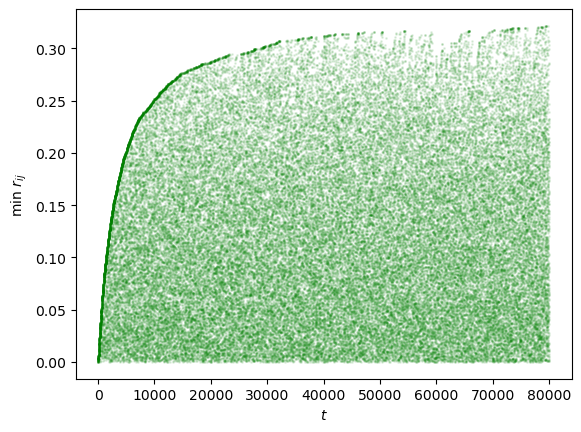

In [4]:
time = [t for t in range(len(grid.minima))]
plt.scatter(time, grid.minima, s=1, alpha = 0.1, color= 'green')

plt.xlabel(r'$t$')
# plt.ylabel('Smallest fitness')
plt.ylabel(r'$\min$ $r_{ij}$')


# plt.scatter(grid.threshold[:, 0], grid.threshold[:, 1], color= 'b', s=2)
plt.show()
# plt.show()

# plt.scatter()
# plt.hist(grid.minima, bins = 30)
# plt.plot(scatter)

## Avalanche size frequency

Investigating avalanche frequency distribution for different grid sizes

m is -1.5036580692070463
b is 7.371363088187098


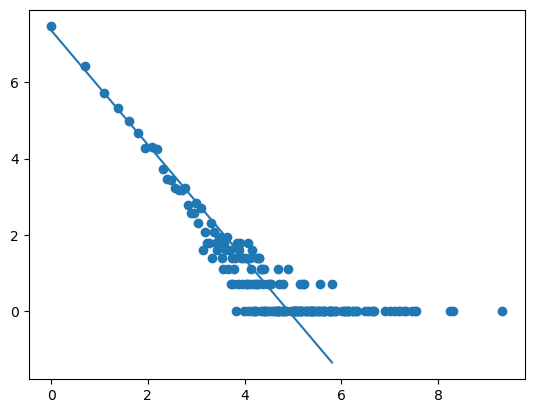

In [5]:
def fit_power_law(data):
    '''Fits the power law using '''
    # Define the power law function
    
    def power_law(x, m, b):
        return m*x+ b
    
    filtered_ones_log = data
    filtered_ones_log = data[data[:, 1] > 0]
    
    logx = filtered_ones_log[:,0]
    logy = filtered_ones_log[:,1]

    
    initial_guess = [2, logy[0]]
    bounds = [(-5,5), (logy[0]-0.5, logy[0]+0.5)]
    
    lower_bounds = [-np.inf,logy[0]-0.1]
    upper_bounds = [np.inf,logy[0]+0.1]
    
    params, covariance = curve_fit(power_law, logx, logy, p0=initial_guess, bounds=(lower_bounds, upper_bounds))
#     params, covariance = curve_fit(power_law, logx, logy)
    # Fit the power law function to the data

    # Get the fitted parameters
    a_fit, b_fit = params
    print(f"m is {a_fit}")
    print(f"b is {b_fit}")

    # Generate fitted curve
    x_fit = np.linspace(logx[0], logx[-1], 10)
    
    y_fit = a_fit*x_fit+(b_fit)

    return x_fit, y_fit , a_fit, b_fit


frequencies = grid.avalanche_frequencies()

log_frequencies = np.log(frequencies)
x, y, m, b  = fit_power_law(log_frequencies)
plt.scatter(log_frequencies[:,0], log_frequencies[:,1])
plt.plot(x, y)


For different grid sizes 

In [6]:
sizes = [25,100,200]
simulations_list = [SimulationGrid(size) for size in sizes]

for s in simulations_list:
    s.run_iterations(100000 ,save=False)

m is -1.3633350968543223
b is 4.627387818712342
m is -1.4534080715698963
b is 7.372500744737559
m is -1.6702496131397042
b is 8.73802580836354


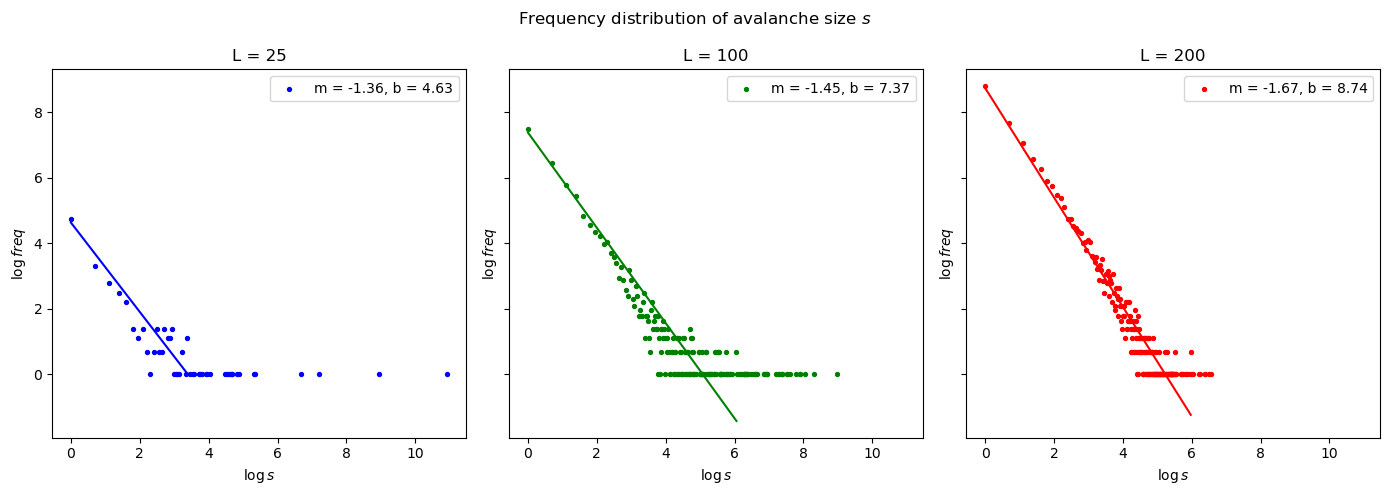

In [7]:
fig, axes = plt.subplots(1, len(simulations_list), sharey=True, sharex=True, figsize=(14, 5))

for indx, (grid, ax) in enumerate(zip(simulations_list, axes)):

    frequencies = grid.avalanche_frequencies()
    log_frequencies = np.log(frequencies)
    x, y , m ,b= fit_power_law(log_frequencies)
    name = f"m = {round(m,2)}, b = {round(b,2)}"
    ysum= np.sum(y)
    colors = ['blue', 'green', 'red']
    
    ax.scatter(log_frequencies[:, 0], log_frequencies[:, 1], color=colors[indx], label=name, s=8)
    ax.plot(x, y, color=colors[indx])

    ax.set_xlabel(r'$\log{s}$')
    ax.set_ylabel(r'$\log{freq}$')
    ax.set_title(f'L = {grid.size}')
    ax.legend()
    # Set x-axis limits
#     ax.set_xlim(-0.2, 8)
plt.suptitle(r'Frequency distribution of avalanche size $s$')

# Add legend to the last subplot
axes[-1].legend()

plt.tight_layout()
plt.show()

#  Innovation 1 Introducing random events

### Avalanche size frequency distribution (By introducing random events)

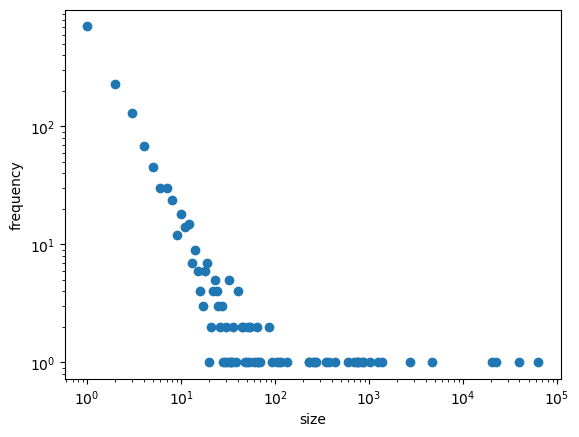

In [9]:
# Running a 100x100 grid 
test = SimulationGrid(100)
test.run_iterations(200000, random_events = True, save=True)



frequencies = test.avalanche_frequencies()
plt.scatter(frequencies[:,0],frequencies[:,1])
plt.ylabel('frequency')
plt.xlabel('size')
plt.xscale('log')
plt.yscale('log')
# plt.plot(frequencies[])

### Time Series of Average Fitness (By introducing random events)

The plot below illustrates the **evolution of the average fitness** in our simulation over time. Each point on the graph represents the average fitness value across all sites on the grid at a given iteration. The average fitness experiences a rapid ascent in the beginning of the simulation. After this initial surge, the average fitness reaches a plateau.

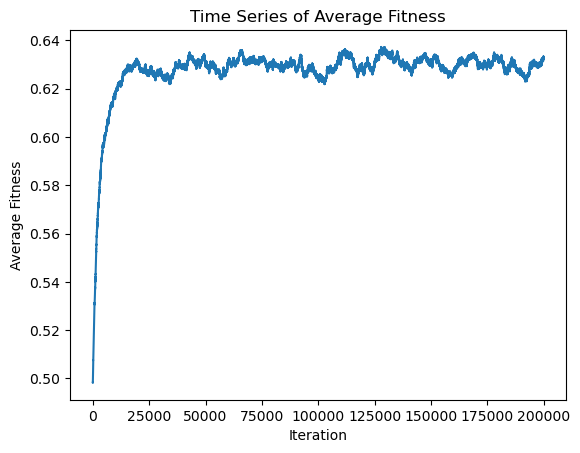

In [10]:
# Calculate average fitness over time
average_fitness = [np.mean(state) for state in test.history]

# Plotting
plt.plot(average_fitness)
plt.title("Time Series of Average Fitness")
plt.xlabel("Iteration")
plt.ylabel("Average Fitness")
plt.show()

### Distribution of Fitness Values at Final State (By introducing random events)

The histogram illustrates the distribution of fitness values of the entire grid at the final state of our simulation. The x-axis represents the range of possible fitness values, while the y-axis indicates the count of sites within each fitness value bin. This skew towards higher fitness values could indicate a bias in the evolutionary rules of the system.

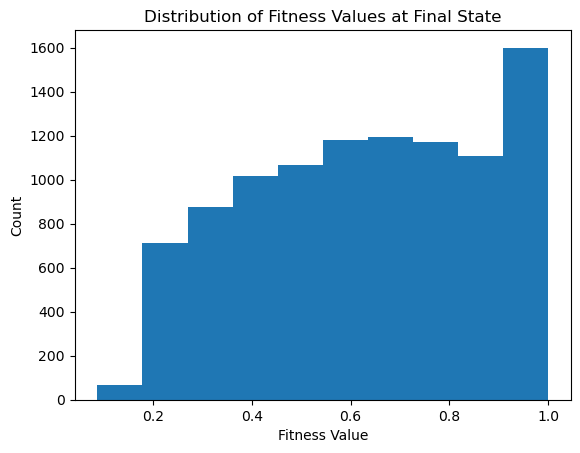

In [11]:
# Assuming fitness_values is a flattened array of grid's fitness values
fitness_values = test.current.ravel()

num_bins = 10  # Giving bin edges at intervals [0, 0.1, 0.2, ..., 0.9, 1.0]

# Plotting histogram of fitness values distribution
plt.hist(fitness_values, bins=num_bins)
plt.title("Distribution of Fitness Values at Final State")
plt.xlabel("Fitness Value")
plt.ylabel("Count")
plt.show()

#  Innovation 2  Exploring bias for benefit or loss from removing worst performing cell

### Running simulation with different biases

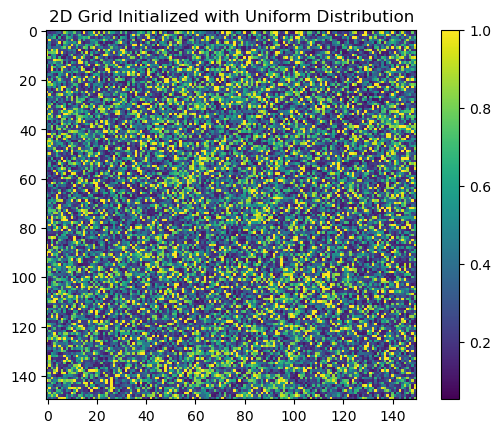

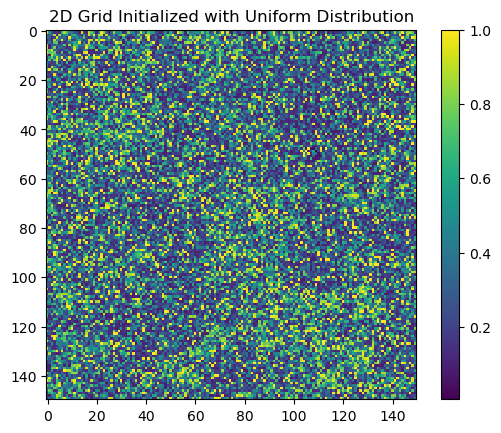

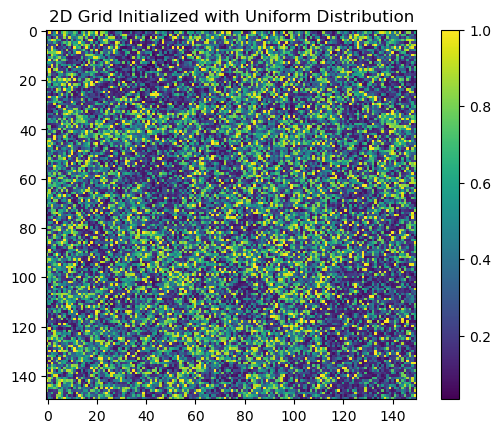

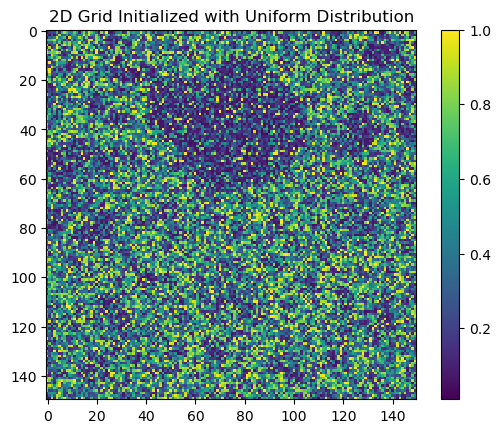

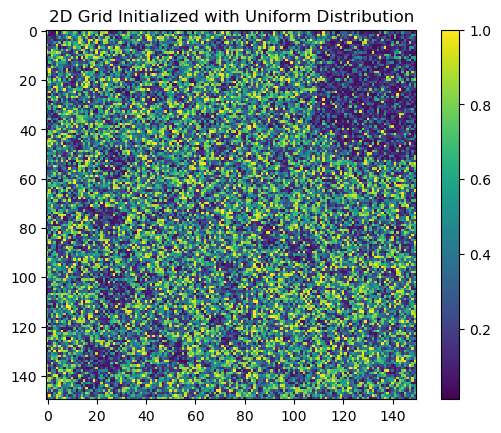

In [25]:
bias_list = np.linspace(0.25, 0.45,5)
grids  = [SimulationGrid(150) for k in range(len(bias_list))]
variance_list = []
means_list = []

for indx,k in enumerate(bias_list):
    grid = grids[indx]
    grid.run_iterations(100000, bias = k , save=False)
    grid.visualize()
    plt.show()
    mean = np.mean(grid.current) 
    means_list.append(mean)
    variance = np.var(grid.current)
    variance_list.append(variance)


### Calculating mean and variance for  different bias k

In [26]:
bias_list = np.linspace(-0.5, 0.5, 20)
grids  = [SimulationGrid(100) for k in range(len(bias_list))]
variance_list = []
means_list = []

for indx,k in enumerate(bias_list):
    grid = grids[indx]
    grid.run_iterations(80000, bias = k, save=False)
#     grid.visualize()
#     plt.show()
    mean = np.mean(grid.current) 
    means_list.append(mean)
    variance = np.var(grid.current)
    variance_list.append(variance)

#### Plotting

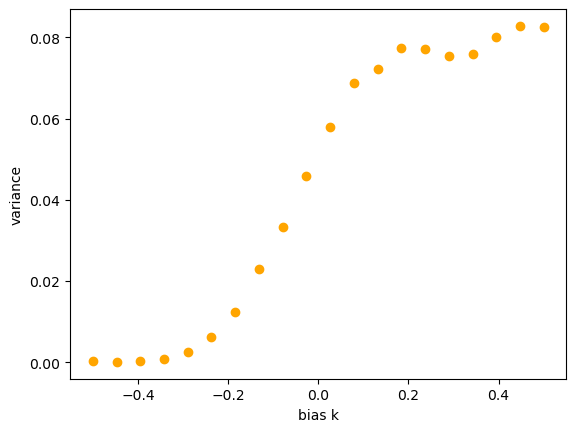

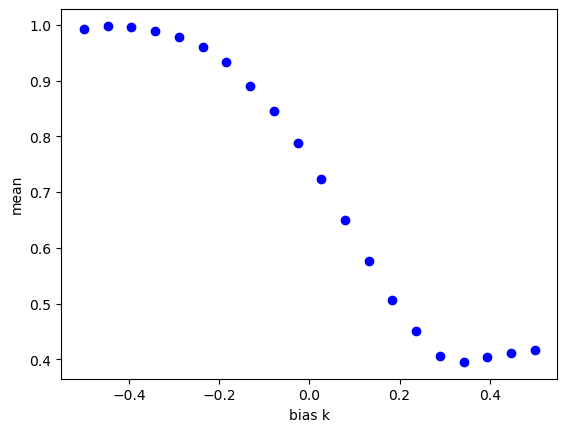

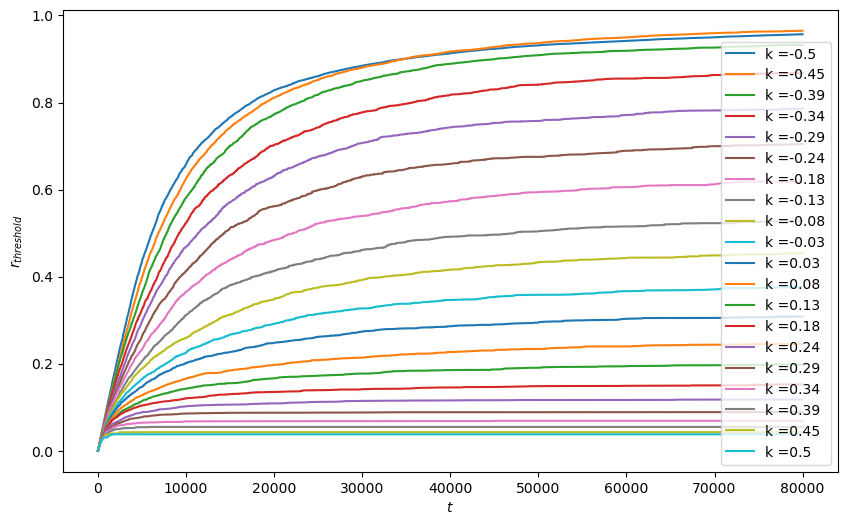

In [27]:
plt.scatter(bias_list, variance_list, color= 'orange')
plt.xlabel('bias k')
plt.ylabel('variance')
plt.show()

plt.scatter(bias_list, means_list, color = 'blue')
plt.xlabel('bias k')
plt.ylabel('mean')
plt.show()


plt.figure(figsize=(10, 6)) 

for indx ,grid in enumerate(grids):
    bias = 'k =' + str(round(bias_list[indx],2))
    plt.plot(grid.threshold[:, 0], grid.threshold[:, 1], label = bias)
    

plt.ylabel(r'$r_{threshold}$')
# plt.xlim(-200,80000)
plt.xlabel('$t$')
plt.legend()
plt.show()


### Studying mean variance with different window size (Not explored in the presentation)

In [28]:
def calculate_variance_with_window(array, window_size):
    variances = []
    rows, cols = array.shape

    for i in range(rows - window_size + 1):
        for j in range(cols - window_size + 1):
            window = array[i:i+window_size, j:j+window_size]
            variance = np.var(window)
            variances.append(variance)

    return variances


# variances = []
# labels = []
# window_sizes = np.arange(0,50,1)

# for grid in grids:
#     variances.append([np.mean(calculate_variance_with_window(grid.current, size)) for size in window_sizes])

# num_colors = 10
# orange_colors = plt.cm.Oranges(np.linspace(0.2, 0.9, num_colors))

# # Convert RGB to hexadecimal
# orange_colors_hex = [plt.cm.colors.rgb2hex(color) for color in orange_colors]


# for i, variance in enumerate(variances):
#     text ='k'+ str(round(bias_list[i],2))
#     plt.plot(window_sizes, variance, label=text, color=orange_colors_hex[i])

# plt.xlabel('window size')
# plt.ylabel('Mean variance')
# plt.legend()
# plt.show()


